In [2]:
#!pip install mkl-service
#!pip install pymc3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 79.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of arviz to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 85.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 88.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━

In [1]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np
import pandas as pd
import pymc as pm
from scipy import stats
from patsy import bs, dmatrix
import pytensor
import pytensor.tensor as pt
import scipy as sp
import scipy.stats as st
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse
from pymc.math import logsumexp
from pymc.variational.callbacks import CheckParametersConvergence
import datetime
from datetime import datetime
from datetime import timedelta
from dateutil.parser import parse

import scipy.fftpack
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import pymc3 as pm
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import matplotlib.dates as mdates
import xarray as xr


#Load Data

In [84]:
country_temp = pd.read_csv("GlobalLandTemperaturesByCountry.csv")

#EDA

In [110]:
country_temp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [111]:
country_temp.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,544811.000000,545550.000000
mean,17.193354,1.019057
std,10.953966,1.201930
min,-37.658000,0.052000
25%,10.025000,0.323000
50%,20.901000,0.571000
75%,25.814000,1.206000
max,38.842000,15.003000


In [112]:
country_temp

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland
...,...,...,...,...
577457,2013-05-01,19.059,1.022,Zimbabwe
577458,2013-06-01,17.613,0.473,Zimbabwe
577459,2013-07-01,17.000,0.453,Zimbabwe
577460,2013-08-01,19.759,0.717,Zimbabwe


In [113]:
country_temp.isnull().sum()

dt                                   0
AverageTemperature               32651
AverageTemperatureUncertainty    31912
Country                              0
dtype: int64

In [114]:
country_temp.shape

(577462, 4)

In [115]:
us_temp = country_temp[country_temp['Country'].isin(['United States'])]

In [116]:
us_temp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
554880,1768-09-01,15.420,2.880,United States
554881,1768-10-01,8.162,3.386,United States
554882,1768-11-01,1.591,3.783,United States
554883,1768-12-01,-2.882,4.979,United States
554884,1769-01-01,-3.952,4.856,United States


#Data Cleaning/Processing

FillNA - AverageTemperatureUncertainty

In [117]:
from sklearn.impute import SimpleImputer

# Create a SimpleImputer object
imputer = SimpleImputer(strategy='mean')

us_temp['AverageTemperatureUncertainty'] = imputer.fit_transform(us_temp[['AverageTemperatureUncertainty']])

<ipython-input-117-b6b0be15b085>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_temp['AverageTemperatureUncertainty'] = imputer.fit_transform(us_temp[['AverageTemperatureUncertainty']])


FillNA - AverageTemperature

In [118]:
# Assuming 'us_temp' is your DataFrame and 'AverageTemperatureUncertainty' is the column name
min_value = us_temp['AverageTemperatureUncertainty'].min()
max_value = us_temp['AverageTemperatureUncertainty'].max()

# Rescale the column to range from 0 to 1
us_temp['AverageTemperatureUncertainty'] = (us_temp['AverageTemperatureUncertainty'] - min_value) / (max_value - min_value)


<ipython-input-118-6d10e49322c6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_temp['AverageTemperatureUncertainty'] = (us_temp['AverageTemperatureUncertainty'] - min_value) / (max_value - min_value)


In [119]:
us_temp['AverageTemperature']= us_temp['AverageTemperature'].interpolate(method='linear')

<ipython-input-119-4ee5fd21d919>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_temp['AverageTemperature']= us_temp['AverageTemperature'].interpolate(method='linear')


In [124]:
us_temp.describe()

,AverageTemperature,AverageTemperatureUncertainty,month,t
count,2941.000000,2941.000000,2941.00000,2941.000000
mean,10.029414,0.147270,6.50085,1470.000000
std,9.103199,0.161624,3.45236,849.137896
min,-7.581000,0.000000,1.00000,0.000000
25%,1.562000,0.026684,4.00000,735.000000
50%,10.361065,0.098978,7.00000,1470.000000
75%,19.463000,0.191522,9.00000,2205.000000
max,23.008000,1.000000,12.00000,2940.000000


In [121]:
us_temp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
554880,1768-09-01,15.420,0.535011,United States
554881,1768-10-01,8.162,0.630772,United States
554882,1768-11-01,1.591,0.705905,United States
554883,1768-12-01,-2.882,0.932248,United States
554884,1769-01-01,-3.952,0.908970,United States


Prune Data to include only max temps per and year

In [123]:
us_temp["dt"] = pd.to_datetime(us_temp["dt"], format="%Y-%m-%d")
us_temp["month"] = us_temp["dt"].dt.month
us_temp["year"] = us_temp["dt"].dt.year
us_temp['t'] = np.arange(len(us_temp))
us_temp = us_temp.set_index("year")
pre = us_temp[us_temp.index < 1930]
post = us_temp[us_temp.index >= 1930]
us_temp["pre"] = us_temp.index < 1930

In [125]:
us_temp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,month,t,pre
year,,,,,,,
1768,1768-09-01,15.420,0.535011,United States,9,0,True
1768,1768-10-01,8.162,0.630772,United States,10,1,True
1768,1768-11-01,1.591,0.705905,United States,11,2,True
1768,1768-12-01,-2.882,0.932248,United States,12,3,True
1769,1769-01-01,-3.952,0.908970,United States,1,4,True


In [126]:
us_temp.tail()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,month,t,pre
year,,,,,,,
2013,2013-05-01,14.073,0.023656,United States,5,2936,False
2013,2013-06-01,20.198,0.034633,United States,6,2937,False
2013,2013-07-01,22.074,0.018736,United States,7,2938,False
2013,2013-08-01,21.168,0.037093,United States,8,2939,False
2013,2013-09-01,18.273,0.218963,United States,9,2940,False


Helper Functions

In [127]:
# helper functions to support the analysis

def ZeroSumNormal(name, *, sigma=None, active_dims=None, dims, model=None):
    model = pm.modelcontext(model=model)

    if isinstance(dims, str):
        dims = [dims]

    if isinstance(active_dims, str):
        active_dims = [active_dims]

    if active_dims is None:
        active_dims = dims[-1]

    def extend_axis(value, axis):
        n_out = value.shape[axis] + 1
        sum_vals = value.sum(axis, keepdims=True)
        norm = sum_vals / (pt.sqrt(n_out) + n_out)
        fill_val = norm - sum_vals / pt.sqrt(n_out)
        out = pt.concatenate([value, fill_val], axis=axis)
        return out - norm

    dims_reduced = []
    active_axes = []
    for i, dim in enumerate(dims):
        if dim in active_dims:
            active_axes.append(i)
            dim_name = f"{dim}_reduced"
            if name not in model.coords:
                model.add_coord(dim_name, length=len(model.coords[dim]) - 1, mutable=False)
            dims_reduced.append(dim_name)
        else:
            dims_reduced.append(dim)

    raw = pm.Normal(f"{name}_raw", sigma=sigma, dims=dims_reduced)
    for axis in active_axes:
        raw = extend_axis(raw, axis)
    return pm.Deterministic(name, raw, dims=dims)


def format_x_axis(ax, minor=False):
    # major ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y %b"))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.grid(which="major", linestyle="-", axis="x")
    # minor ticks
    if minor:
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y %b"))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(which="minor", linestyle=":", axis="x")
    # rotate labels
    for label in ax.get_xticklabels(which="both"):
        label.set(rotation=70, horizontalalignment="right")


def plot_xY(x, Y, ax, label=''):
    quantiles = Y.quantile((0.025, 0.25, 0.5, 0.75, 0.975), dim=("chain", "draw")).transpose()

    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.025, 0.975]),
        fill_kwargs={"alpha": 0.25},
        smooth=False,
        ax=ax,
    )
    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.25, 0.75]),
        fill_kwargs={"alpha": 0.5},
        smooth=False,
        ax=ax,
    )
    ax.plot(x, quantiles.sel(quantile=0.5), color="C1", lw=3, label=label)


# default figure sizes
figsize = (10, 5)

import calendar
import os
# create a list of month strings, for plotting purposes
month_strings = calendar.month_name[1:]

<Axes: xlabel='year', ylabel='AverageTemperature'>

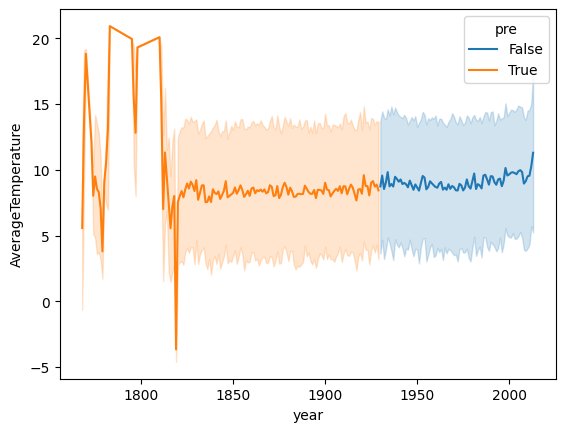

In [132]:
ax = sns.lineplot(data=us_temp, x="year", y="AverageTemperature", hue="pre")
ax

In [133]:
us_temp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,month,t,pre
year,,,,,,,
1768,1768-09-01,15.420,0.535011,United States,9,0,True
1768,1768-10-01,8.162,0.630772,United States,10,1,True
1768,1768-11-01,1.591,0.705905,United States,11,2,True
1768,1768-12-01,-2.882,0.932248,United States,12,3,True
1769,1769-01-01,-3.952,0.908970,United States,1,4,True


In [134]:
us_temp.describe()

,AverageTemperature,AverageTemperatureUncertainty,month,t
count,2941.000000,2941.000000,2941.00000,2941.000000
mean,10.029414,0.147270,6.50085,1470.000000
std,9.103199,0.161624,3.45236,849.137896
min,-7.581000,0.000000,1.00000,0.000000
25%,1.562000,0.026684,4.00000,735.000000
50%,10.361065,0.098978,7.00000,1470.000000
75%,19.463000,0.191522,9.00000,2205.000000
max,23.008000,1.000000,12.00000,2940.000000


In [135]:
us_temp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,month,t,pre
year,,,,,,,
1768,1768-09-01,15.420,0.535011,United States,9,0,True
1768,1768-10-01,8.162,0.630772,United States,10,1,True
1768,1768-11-01,1.591,0.705905,United States,11,2,True
1768,1768-12-01,-2.882,0.932248,United States,12,3,True
1769,1769-01-01,-3.952,0.908970,United States,1,4,True


In [136]:
us_temp.describe()

,AverageTemperature,AverageTemperatureUncertainty,month,t
count,2941.000000,2941.000000,2941.00000,2941.000000
mean,10.029414,0.147270,6.50085,1470.000000
std,9.103199,0.161624,3.45236,849.137896
min,-7.581000,0.000000,1.00000,0.000000
25%,1.562000,0.026684,4.00000,735.000000
50%,10.361065,0.098978,7.00000,1470.000000
75%,19.463000,0.191522,9.00000,2205.000000
max,23.008000,1.000000,12.00000,2940.000000


#EDA PT. 2

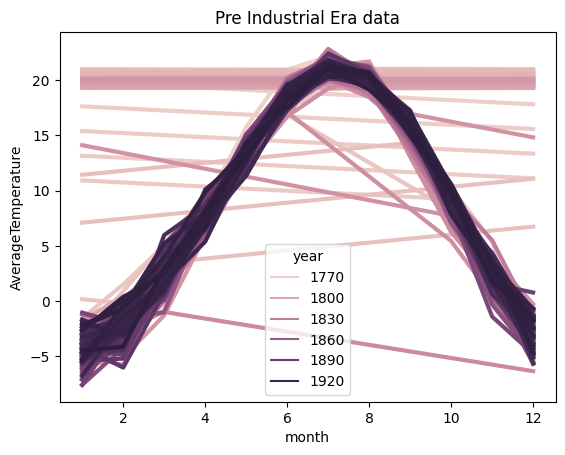

In [140]:
ax = sns.lineplot(data=pre, x="month", y="AverageTemperature", hue="year", lw=3)
ax.set(title="Pre Industrial Era data");

In [144]:
us_temp["Year"] = us_temp["dt"].dt.year

In [147]:
us_temp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,month,t,pre,Year
year,,,,,,,,
1768,1768-09-01,15.420,0.535011,United States,9,0,True,1768
1768,1768-10-01,8.162,0.630772,United States,10,1,True,1768
1768,1768-11-01,1.591,0.705905,United States,11,2,True,1768
1768,1768-12-01,-2.882,0.932248,United States,12,3,True,1768
1769,1769-01-01,-3.952,0.908970,United States,1,4,True,1769


In [148]:
us_temp.columns

Index(['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'Country',
       'month', 't', 'pre', 'Year'],
      dtype='object')

In [150]:
pre.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,month,t,Year
year,,,,,,,
1768,1768-09-01,15.420,0.535011,United States,9,0,1768
1768,1768-10-01,8.162,0.630772,United States,10,1,1768
1768,1768-11-01,1.591,0.705905,United States,11,2,1768
1768,1768-12-01,-2.882,0.932248,United States,12,3,1768
1769,1769-01-01,-3.952,0.908970,United States,1,4,1769


In [153]:
#pre['Year'] = pd.to_datetime(pre["dt"], format="%Y-%m-%d").dt.year
post['Year'] = pd.to_datetime(post["dt"], format="%Y-%m-%d").dt.year


<ipython-input-153-21e6f9f141f3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post['Year'] = pd.to_datetime(post["dt"], format="%Y-%m-%d").dt.year


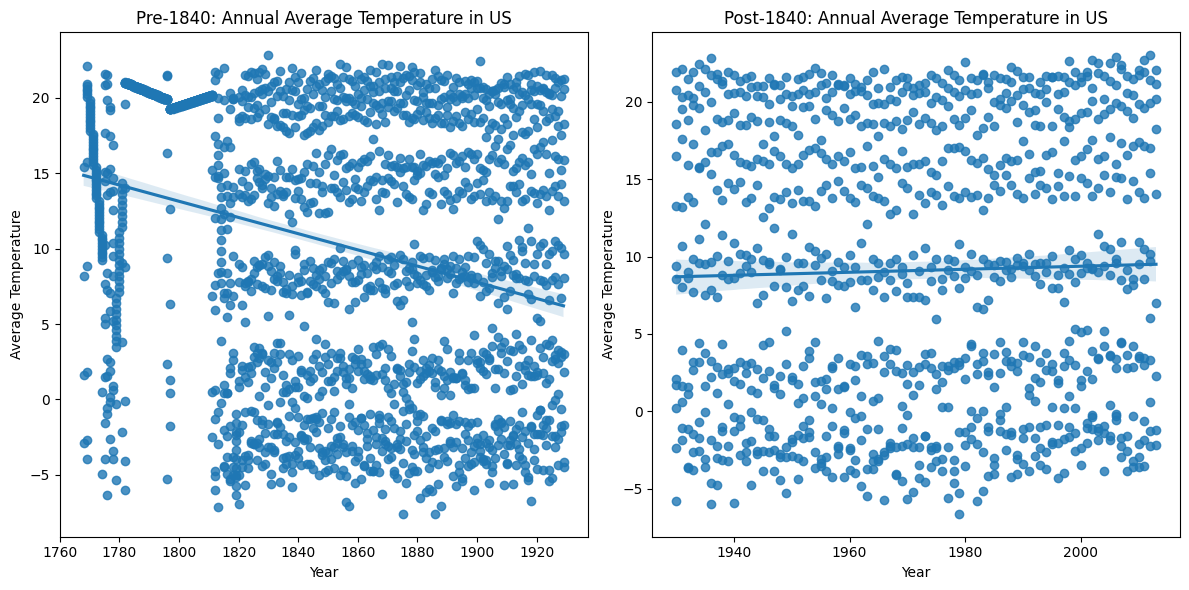

In [154]:
# Creating regression plots for pre-1840 and post-1840 periods
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.regplot(x='Year', y='AverageTemperature', data=pre)
plt.title('Pre-1840: Annual Average Temperature in US')
plt.xlabel('Year')
plt.ylabel('Average Temperature')

plt.subplot(1, 2, 2)
sns.regplot(x='Year', y='AverageTemperature', data=post)
plt.title('Post-1840: Annual Average Temperature in US')
plt.xlabel('Year')
plt.ylabel('Average Temperature')

plt.tight_layout()
plt.show()

#Bayesian Modeling

In [155]:
us_temp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,month,t,pre,Year
year,,,,,,,,
1768,1768-09-01,15.420,0.535011,United States,9,0,True,1768
1768,1768-10-01,8.162,0.630772,United States,10,1,True,1768
1768,1768-11-01,1.591,0.705905,United States,11,2,True,1768
1768,1768-12-01,-2.882,0.932248,United States,12,3,True,1768
1769,1769-01-01,-3.952,0.908970,United States,1,4,True,1769


In [156]:
pre.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,month,t,Year
year,,,,,,,
1768,1768-09-01,15.420,0.535011,United States,9,0,1768
1768,1768-10-01,8.162,0.630772,United States,10,1,1768
1768,1768-11-01,1.591,0.705905,United States,11,2,1768
1768,1768-12-01,-2.882,0.932248,United States,12,3,1768
1769,1769-01-01,-3.952,0.908970,United States,1,4,1769


In [157]:
us_temp.describe()

,AverageTemperature,AverageTemperatureUncertainty,month,t,Year
count,2941.000000,2941.000000,2941.00000,2941.000000,2941.000000
mean,10.029414,0.147270,6.50085,1470.000000,1890.708262
std,9.103199,0.161624,3.45236,849.137896,70.762354
min,-7.581000,0.000000,1.00000,0.000000,1768.000000
25%,1.562000,0.026684,4.00000,735.000000,1829.000000
50%,10.361065,0.098978,7.00000,1470.000000,1891.000000
75%,19.463000,0.191522,9.00000,2205.000000,1952.000000
max,23.008000,1.000000,12.00000,2940.000000,2013.000000


In [165]:
pre["month"].shape

(1936,)

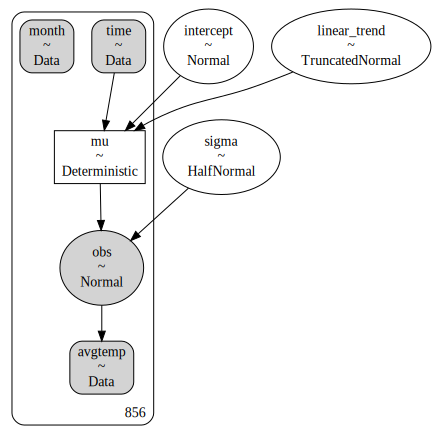

In [97]:
g

In [99]:
random_seed= 8927
figsize= (10,6)

In [227]:
with pm.Model(coords={"month": month_strings}) as model:
    # observed predictors and outcome
    month = pm.Data("month", pre["month"].to_numpy())
    time = pm.Data("time", pre["t"].to_numpy())
    avgtemp = pm.Data("avgtemp", pre["AverageTemperature"].to_numpy())

    # priors
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    linear_trend = pm.TruncatedNormal("linear_trend", 0, 50, lower=0)

    # the actual linear model
    mu = pm.Deterministic(
        "mu",
        intercept + (linear_trend * time),
    )
    sigma = pm.HalfNormal("sigma", 1)

    # likelihood
    pm.Normal("obs", mu=mu, sigma=sigma, observed=avgtemp)

    # Prior predictive samples
    prior_trace = pm.sample_prior_predictive()
    g = pm.model_to_graphviz()


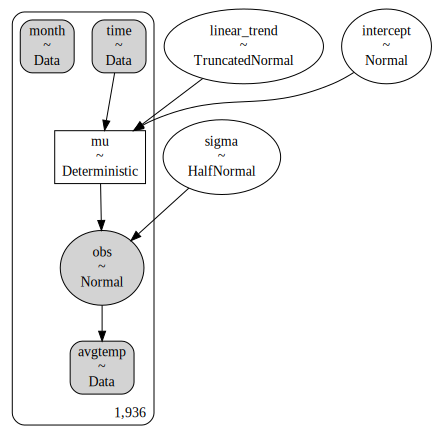

In [192]:
g

In [194]:
random_seed= 1234

In [213]:
def plot_xY(x, Y, ax, label=''):
    quantiles = np.percentile(Y, (2.5, 25, 50, 75, 97.5), axis=0)

    ax.fill_between(x, quantiles[0], quantiles[-1], alpha=0.25, label='95% CI')
    ax.fill_between(x, quantiles[1], quantiles[3], alpha=0.5, label='50% CI')
    ax.plot(x, quantiles[2], color='C1', lw=3, label=label)
    # Additional customization can be added here for axis labels, titles, legends, etc.
    # ax.set_xlabel('X-axis label')
    # ax.set_ylabel('Y-axis label')
    # ax.set_title('Title')
    # ax.legend()


In [229]:
idata.keys()

dict_keys(['sigma_log__', 'obs', 'mu', 'intercept', 'linear_trend', 'sigma', 'linear_trend_lowerbound__'])

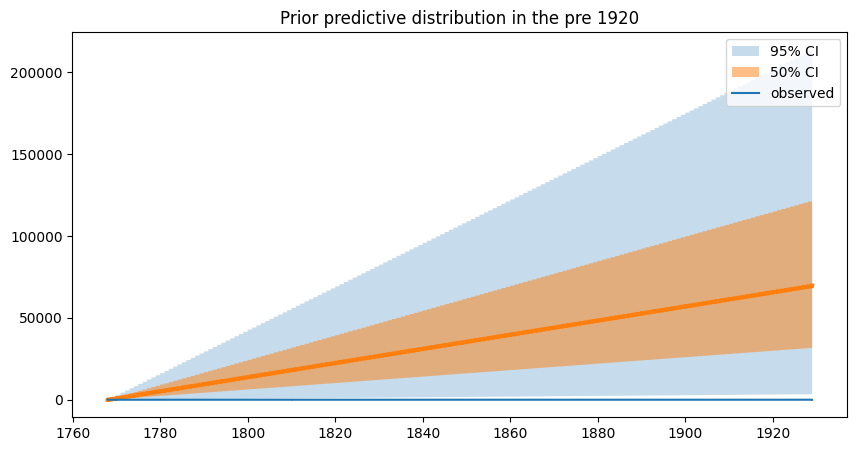

In [231]:
with model:
    prior_trace = pm.sample_prior_predictive()

fig, ax = plt.subplots(figsize=(10, 5))

plot_xY(pre["Year"], prior_trace["obs"], ax)
ax.plot(pre["Year"], pre["AverageTemperature"], label="observed")
ax.set(title="Prior predictive distribution in the pre 1920")
plt.legend()


In [ ]:
az.summary(trace)
az.plot_trace(trace)

In [145]:
pre_industrial.describe()

,AverageTemperature,AverageTemperatureUncertainty,Year,month,t
count,856.000000,856.000000,856.000000,856.000000,856.000000
mean,13.170814,0.294539,1803.831776,6.518692,427.500000
std,8.658497,0.188325,20.604881,3.457630,247.250211
min,-7.130000,0.147270,1768.000000,1.000000,0.000000
25%,7.385500,0.147270,1786.000000,4.000000,213.750000
50%,18.495435,0.147270,1804.000000,7.000000,427.500000
75%,20.047392,0.416824,1822.000000,10.000000,641.250000
max,22.816000,1.000000,1839.000000,12.000000,855.000000


/usr/local/lib/python3.10/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


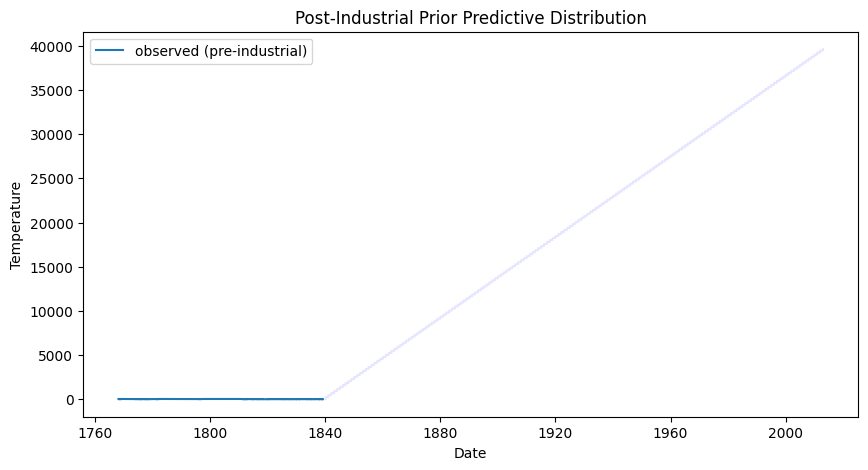

In [143]:
import pandas as pd
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import calendar

# Assuming 'us_temp' DataFrame contains relevant temperature data
# Creating a column 'date' and setting it as index
us_temp["date"] = pd.to_datetime(us_temp["Year"], format='%Y')
us_temp = us_temp.set_index("date")

# Splitting into separate dataframes for pre and post-Industrial era
pre_industrial = us_temp[us_temp.index < "1840"]
post_industrial = us_temp[us_temp.index >= "1840"]

# create a list of month strings, for plotting purposes
month_strings = calendar.month_name[1:]

# PyMC3 model
with pm.Model(coords={"month": month_strings}) as model:
    # observed predictors and outcome for pre-industrial era
    month = pm.Data("month", pre_industrial["month"].to_numpy())
    time = pm.Data("time", pre_industrial["t"].to_numpy())
    avgtemp = pm.Data("avgtemp", pre_industrial["AverageTemperature"].to_numpy())

    # priors
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    linear_trend = pm.TruncatedNormal("linear_trend", 0, 50, lower=0)

    # the actual linear model for pre-industrial era
    mu_pre = pm.Deterministic(
        "mu_pre",
        intercept + (linear_trend * time),
    )
    sigma = pm.HalfNormal("sigma", 1)

    # likelihood for pre-industrial era
    pm.Normal("obs_pre", mu=mu_pre, sigma=sigma, observed=avgtemp)

    # Model fitting for pre-industrial era
    trace_pre = pm.sample(2000, tune=1000, init='advi+adapt_diag', target_accept=0.95)

    # PyMC3's sample_prior_predictive for post-industrial era
    idata = pm.sample_prior_predictive(random_seed=42)
    prior_trace = idata["obs_pre"]

upsampled_samples = np.interp(
    np.linspace(0, len(sample) - 1, len(post_industrial.index)),
    np.arange(len(sample)),
    sample
)

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(post_industrial.index, upsampled_samples, color='blue', alpha=0.1)
ax.plot(pre_industrial.index, pre_industrial["AverageTemperature"], label="observed (pre-industrial)")
ax.set(title="Post-Industrial Prior Predictive Distribution", xlabel="Date", ylabel="Temperature")
plt.ylim(0, 30)  # Set the y-axis limits from 0 to 30
plt.legend()
plt.show()


In [141]:
print(idata.keys())


dict_keys(['sigma_log__', 'intercept', 'linear_trend', 'obs_pre', 'linear_trend_lowerbound__', 'sigma', 'mu_pre'])


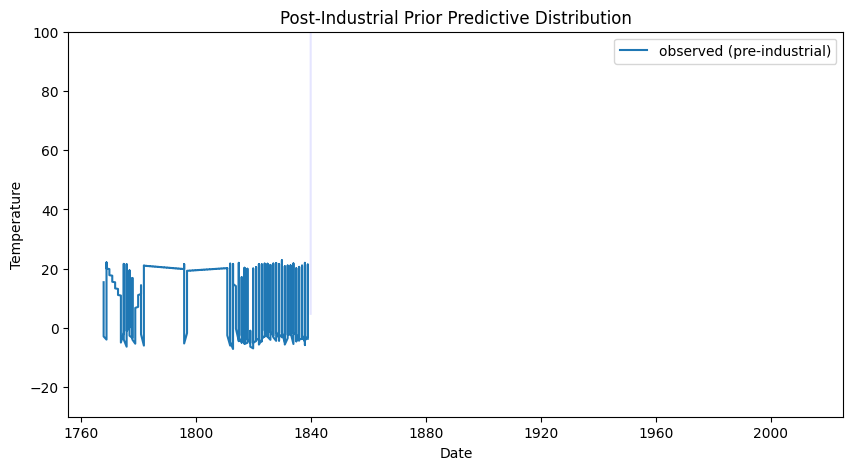

In [148]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(post_industrial.index, upsampled_samples, color='blue', alpha=0.1)
ax.plot(pre_industrial.index, pre_industrial["AverageTemperature"], label="observed (pre-industrial)")
ax.set(title="Post-Industrial Prior Predictive Distribution", xlabel="Date", ylabel="Temperature")
plt.ylim(-30, 100)  # Set the y-axis limits from 0 to 30
plt.legend()
plt.show()


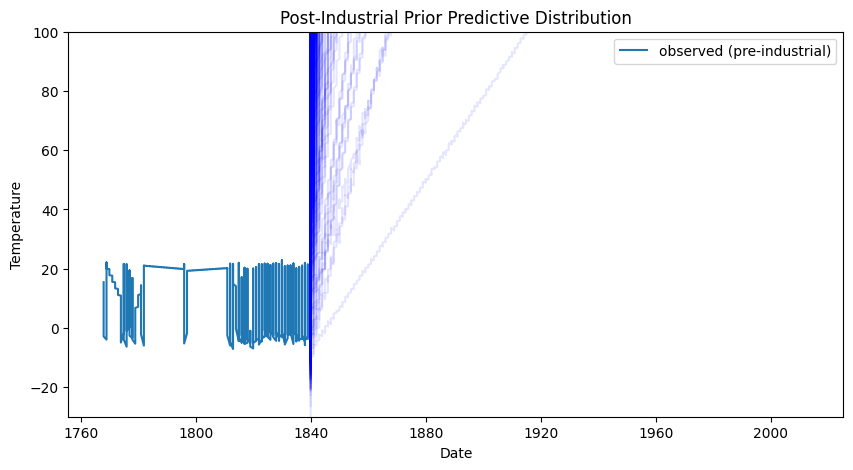

In [150]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the prior predictive distribution for the post-Industrial era
for sample in prior_trace:
    upsampled_samples = np.interp(
        np.linspace(0, len(sample) - 1, len(post_industrial.index)),
        np.arange(len(sample)),
        sample
    )
    ax.plot(post_industrial.index, upsampled_samples, color='blue', alpha=0.1)

# Plot the observed pre-Industrial temperatures
ax.plot(pre_industrial.index, pre_industrial["AverageTemperature"], label="observed (pre-industrial)")

# Set plot labels and title
ax.set(title="Post-Industrial Prior Predictive Distribution", xlabel="Date", ylabel="Temperature")

# Set the y-axis limits from 0 to 30
plt.ylim(-30, 100)

plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


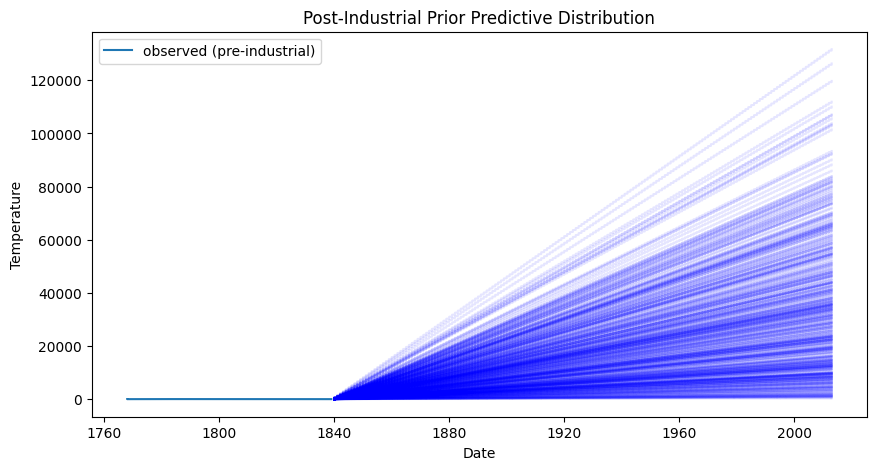

In [151]:
# Assuming 'us_temp' DataFrame contains relevant temperature data
# Creating a column 'date' and setting it as index
us_temp["date"] = pd.to_datetime(us_temp["Year"], format='%Y')
us_temp = us_temp.set_index("date")

# Splitting into separate dataframes for pre and post-Industrial era
pre_industrial = us_temp[us_temp.index < "1840"]
post_industrial = us_temp[us_temp.index >= "1840"]

# create a list of month strings, for plotting purposes
month_strings = calendar.month_name[1:]

# PyMC3 model
with pm.Model(coords={"month": month_strings}) as model:
    # observed predictors and outcome for pre-industrial era
    month = pm.Data("month", pre_industrial["month"].to_numpy())
    time = pm.Data("time", pre_industrial["t"].to_numpy())
    avgtemp = pm.Data("avgtemp", pre_industrial["AverageTemperature"].to_numpy())

    # priors
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    linear_trend = pm.TruncatedNormal("linear_trend", 0, 50, lower=0)

    # the actual linear model for pre-industrial era
    mu_pre = pm.Deterministic(
        "mu_pre",
        intercept + (linear_trend * time),
    )
    sigma = pm.HalfNormal("sigma", 1)

    # likelihood for pre-industrial era
    pm.Normal("obs_pre", mu=mu_pre, sigma=sigma, observed=avgtemp)

    # Model fitting for pre-industrial era
    trace_pre = pm.sample(2000, tune=1000, init='advi+adapt_diag', target_accept=0.95)

    # PyMC3's sample_prior_predictive for post-industrial era
    idata = pm.sample_prior_predictive(random_seed=42)
    prior_trace = idata["obs_pre"]

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the prior predictive distribution for the post-Industrial era
for sample in prior_trace:
    upsampled_samples = np.interp(
        np.linspace(0, len(sample) - 1, len(post_industrial.index)),
        np.arange(len(sample)),
        sample
    )
    ax.plot(post_industrial.index, upsampled_samples, color='blue', alpha=0.1)

# Plot the observed pre-Industrial temperatures
ax.plot(pre_industrial.index, pre_industrial["AverageTemperature"], label="observed (pre-industrial)")

# Set plot labels and title
ax.set(title="Post-Industrial Prior Predictive Distribution", xlabel="Date", ylabel="Temperature")

plt.legend()
plt.show()
